## Deduplication of results

Naivy deduplication for now - just use DOI and title

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Review

Defining used columns and making directionary for merge WoS and Scopus

In [311]:
dfReviewScopus = pd.read_csv('bulk_data/review_scopus.csv')
dfReviewWOS = pd.read_csv('data/review_wos.csv')

## Fill additional data
dfReviewScopus['Date of Export'] = '2023-01-24'
dfReviewWOS['Source'] = 'Web of Science'
dfReviewScopus['Link'] = 'https://dx.doi.org/' + dfReviewScopus['DOI']
dfReviewWOS['Link'] = 'https://dx.doi.org/' + dfReviewWOS['DOI']
dfReviewWOS['Publication Year'] = dfReviewWOS['Publication Year'].astype('Int64')

## Remove rows without DOI
dfReviewScopus = dfReviewScopus[dfReviewScopus['DOI'].notnull()]
dfReviewWOS = dfReviewWOS[dfReviewWOS['DOI'].notnull()]

print('Scopus len:', len(dfReviewScopus), ', removed', 685 - len(dfReviewScopus), 'without DOI')
print('WoS len:', len(dfReviewWOS), 'removed', 607 - len(dfReviewWOS), 'without DOI')

Scopus len: 666 , removed 19 without DOI
WoS len: 598 removed 9 without DOI


In [312]:
print('Scopus columns:', dfReviewScopus.columns.values)
print('WoS columns:', dfReviewWOS.columns.values)

Scopus columns: ['Authors' 'Author(s) ID' 'Title' 'Year' 'Source title' 'Volume' 'Issue'
 'Art. No.' 'Page start' 'Page end' 'Page count' 'Cited by' 'DOI' 'Link'
 'Affiliations' 'Authors with affiliations' 'Abstract' 'Author Keywords'
 'Index Keywords' 'References' 'Correspondence Address' 'Editors'
 'Publisher' 'ISSN' 'ISBN' 'CODEN' 'PubMed ID'
 'Language of Original Document' 'Abbreviated Source Title'
 'Document Type' 'Publication Stage' 'Open Access' 'Source' 'EID'
 'Date of Export']
WoS columns: ['index' 'Publication Type' 'Authors' 'Author Full Names' 'Group Authors'
 'Article Title' 'Source Title' 'Language' 'Document Type'
 'Conference Title' 'Conference Date' 'Conference Location'
 'Conference Sponsor' 'Conference Host' 'Author Keywords' 'Keywords Plus'
 'Abstract' 'Addresses' 'Affiliations' 'Reprint Addresses'
 'Email Addresses' 'Researcher Ids' 'ORCIDs' 'Funding Orgs'
 'Funding Name Preferred' 'Funding Text' 'Cited References'
 'Cited Reference Count' 'Times Cited, WoS Core'

In [313]:
columns_scopus = [
    'Authors', 'Title', 'Year', 'Source title', 'DOI', 'Link', 'Author Keywords', 
    'Affiliations', 'Abstract', 'Cited by', 'References', 'Publisher', 'ISSN', 
    'Language of Original Document', 'Document Type', 'Source', 'Date of Export'
]

columns_wos = [
    'Authors', 'Article Title', 'Publication Year', 'Source title', 'DOI', 'Link', 'Author Keywords', 
    'Affiliations', 'Abstract', 'Times Cited, All Databases', 'Cited References', 'Publisher', 'ISSN', 
    'Language', 'Document Type', 'Source', 'Date of Export'
]

final_columns = [
    'Authors', 'Title', 'Year', 'Source title', 'DOI', 'Link', 'Author Keywords', 
    'Affiliations', 'Abstract', 'Number citation', 'References', 'Publisher', 'ISSN', 
    'Language', 'Document Type', 'Source', 'Date of Export'
]

In [314]:
drop_columns = set(dfReviewScopus.columns.values) - set(columns_scopus)
rename_columns = dict(zip(columns_scopus, final_columns))

dfReviewScopus.drop(columns=drop_columns, inplace=True)
dfReviewScopus.rename(columns=rename_columns, inplace=True)

drop_columns = set(dfReviewWOS.columns.values) - set(columns_wos)
rename_columns = dict(zip(columns_wos, final_columns))

dfReviewWOS.drop(columns=drop_columns, inplace=True)
dfReviewWOS.rename(columns=rename_columns, inplace=True)

Test to prepare merge

In [315]:
## Filtering by tittle

print('Scopus len:', len(dfReviewScopus))
print('WoS len:', len(dfReviewWOS))

titleScopus = dfReviewScopus['Title'].str.strip(' .').str.lower().tolist()
titleWoS = dfReviewWOS['Title'].str.strip(' .').str.lower().tolist()

titleMerge = list(set(titleScopus + titleWoS))

print('Merge len:', len(titleMerge), 'removed:', len(dfReviewScopus) + len(dfReviewWOS) - len(titleMerge))

Scopus len: 666
WoS len: 598
Merge len: 879 removed: 385


In [316]:
## Filtering by DOI - used option

print('Scopus len:', len(dfReviewScopus))
print('WoS len:', len(dfReviewWOS))

doiScopus = dfReviewScopus['DOI'].tolist()
doiWoS = dfReviewWOS['DOI'].tolist()

doiMerge = list(set(doiScopus + doiWoS))

print('Merge len:', len(doiMerge), 'removed:', len(dfReviewScopus) + len(dfReviewWOS) - len(doiMerge))

Scopus len: 666
WoS len: 598
Merge len: 849 removed: 415


In [317]:
print('Estimated number of valid abstract results for review:', round((19/50)*849))

Estimated number of valid abstract results for review: 323


Merge dataframes, removing duplicates by DOI

In [318]:
for idx, row in dfReviewScopus.iterrows():
    if row.DOI in dfReviewWOS.DOI.values:
        dfReviewScopus.loc[idx, 'Source'] = 'Scopus;Web of Science'
        
dfReview = pd.concat([dfReviewScopus, dfReviewWOS], ignore_index=True)[final_columns]
dfReview.drop_duplicates(subset=['DOI'], keep='first', inplace=True)

In [319]:
print('Final length:', len(dfReview))
dfReview.head()

Final length: 849


,Authors,Title,Year,Source title,DOI,Link,Author Keywords,Affiliations,Abstract,Number citation,References,Publisher,ISSN,Language,Document Type,Source,Date of Export
0,"Nipa T.J., Kermanshachi S., Pamidimukkala A.",Identification of Resilience Dimensions in Cri...,2023,Journal of Legal Affairs and Dispute Resolutio...,10.1061/JLADAH.LADR-870,https://dx.doi.org/10.1061/JLADAH.LADR-870,Critical transportation infrastructure; Natura...,"Dept. of Civil Engineering, Univ. of Texas at ...",Incorporating resilience into transportation i...,NaN,"Adger, W.N., Social and ecological resilience:...",American Society of Civil Engineers (ASCE),19434162,English,Review,Scopus,2023-01-24
1,"Ong A.D., Liu Z., Cintron D.W.",Five challenges for hope and resilience research,2023,Current Opinion in Psychology,10.1016/j.copsyc.2022.101538,https://dx.doi.org/10.1016/j.copsyc.2022.101538,Hope; Measurement; Mental health; Resilience; ...,"Department of Psychology, Cornell University, ...",Twenty years after Snyder's seminar article on...,NaN,"Snyder, C.R., Hope theory: rainbows in the min...",Elsevier B.V.,2352250X,English,Review,Scopus,2023-01-24
2,"Rai P.K., Sonne C., Song H., Kim K.-H.",Plastic wastes in the time of COVID-19: Their ...,2023,Science of the Total Environment,10.1016/j.scitotenv.2022.159880,https://dx.doi.org/10.1016/j.scitotenv.2022.15...,Biorefinery; Circular economy; Climate-smart h...,"Phyto-Technologies and Plant Invasion Lab, Dep...",The global scope of pollution from plastic was...,NaN,"Abokalawa, F., The effects of coronavirus dise...",Elsevier B.V.,00489697,English,Review,Scopus,2023-01-24
3,"SmithBattle L., Phengnum W.",An Integrative Review of the Research on Teen ...,2023,Western Journal of Nursing Research,10.1177/01939459221106989,https://dx.doi.org/10.1177/01939459221106989,adolescent mothers; adverse childhood experien...,"Trudy Busch Valentine School of Nursing, Saint...",Greater attention to teen mothers’ strengths a...,NaN,"Acabchuk, R.L., Kamath, J., Salamone, J.D., Jo...",SAGE Publications Inc.,01939459,English,Review,Scopus;Web of Science,2023-01-24
4,Zhou Y.,Climate change adaptation with energy resilien...,2023,Energy and Buildings,10.1016/j.enbuild.2022.112649,https://dx.doi.org/10.1016/j.enbuild.2022.112649,Climate adaptation; Decarbonisation; District ...,"Sustainable Energy and Environment Thrust, Fun...","Energy efficiency, flexibility, and robustness...",2.0,"Davis, S.J., Lewis, N.S., Shaner, M., Aggarwal...",Elsevier Ltd,03787788,English,Review,Scopus;Web of Science,2023-01-24


In [320]:
dfReview.drop(columns=['Abstract', 'References']).to_csv('data/meta_review.csv', index_label='index')

### Modeling

In [321]:
dfModelScopus1 = pd.read_csv('bulk_data/model_scopus_1.csv')
dfModelScopus2 = pd.read_csv('bulk_data/model_scopus_2.csv')
dfModelScopus = pd.concat([dfModelScopus1, dfModelScopus2])

dfModelWOS = pd.read_csv('data/model_wos.csv', index_col=0)

## Fill additional data
dfModelScopus['Date of Export'] = '2023-01-24'
dfModelWOS['Source'] = 'Web of Science'
dfModelScopus['Link'] = 'https://dx.doi.org/' + dfModelScopus['DOI']
dfModelWOS['Link'] = 'https://dx.doi.org/' + dfModelWOS['DOI']
dfModelWOS['Publication Year'] = dfModelWOS['Publication Year'].astype('Int64')

## Remove rows without DOI
dfModelScopus = dfModelScopus[dfModelScopus['DOI'].notnull()]
dfModelWOS = dfModelWOS[dfModelWOS['DOI'].notnull()]

print('Scopus len:', len(dfModelScopus), ', removed', 3689 - len(dfModelScopus), 'without DOI')
print('WoS len:', len(dfModelWOS), ', removed', 4630 - len(dfModelWOS), 'without DOI')

Scopus len: 3483 , removed 206 without DOI
WoS len: 4309 , removed 321 without DOI


In [322]:
columns_scopus = [
    'Authors', 'Title', 'Year', 'Source title', 'DOI', 'Link', 'Author Keywords', 
    'Affiliations', 'Abstract', 'Cited by', 'References', 'Publisher', 'ISSN', 
    'Language of Original Document', 'Document Type', 'Source', 'Date of Export'
]

columns_wos = [
    'Authors', 'Article Title', 'Publication Year', 'Source title', 'DOI', 'Link', 'Author Keywords', 
    'Affiliations', 'Abstract', 'Times Cited, All Databases', 'Cited References', 'Publisher', 'ISSN', 
    'Language', 'Document Type', 'Source', 'Date of Export'
]

final_columns = [
    'Authors', 'Title', 'Year', 'Source title', 'DOI', 'Link', 'Author Keywords', 
    'Affiliations', 'Abstract', 'Number citation', 'References', 'Publisher', 'ISSN', 
    'Language', 'Document Type', 'Source', 'Date of Export'
]

In [323]:
drop_columns = set(dfModelScopus.columns.values) - set(columns_scopus)
rename_columns = dict(zip(columns_scopus, final_columns))

dfModelScopus.drop(columns=drop_columns, inplace=True)
dfModelScopus.rename(columns=rename_columns, inplace=True)

drop_columns = set(dfModelWOS.columns.values) - set(columns_wos)
rename_columns = dict(zip(columns_wos, final_columns))

dfModelWOS.drop(columns=drop_columns, inplace=True)
dfModelWOS.rename(columns=rename_columns, inplace=True)

Test to prepare to merge

In [324]:
## Filtering by title 

print('Scopus len:', len(dfModelScopus))
print('WoS len:', len(dfModelWOS))

titleScopus = dfModelScopus['Title'].str.strip(' .').str.lower().tolist()
titleWoS = dfModelWOS['Title'].str.strip(' .').str.lower().tolist()

titleMerge = list(set(titleScopus + titleWoS))

print('Merge len:', len(titleMerge), 'removed:', len(dfModelScopus) + len(dfModelWOS) - len(titleMerge))

Scopus len: 3483
WoS len: 4309
Merge len: 5821 removed: 1971


In [325]:
## Filtering by DOI - used option

print('Scopus len:', len(dfModelScopus))
print('WoS len:', len(dfModelWOS))

doiScopus = dfModelScopus['DOI'].tolist()
doiWoS = dfModelWOS['DOI'].tolist()

doiMerge = list(set(doiScopus + doiWoS))

print('Merge len:', len(doiMerge), 'removed:', len(dfModelScopus) + len(dfModelWOS) - len(doiMerge))

Scopus len: 3483
WoS len: 4309
Merge len: 5712 removed: 2080


In [326]:
valid_model = round((20/50)*5712)
print('Estimated number of valid abstract results for model (20 de 50):', valid_model)

valid_model = round((10/50)*5712)
print('Estimated number of valid abstract results for model (10 de 50):', valid_model)

sample_ratio = 0.6
print('\nConsidering 1 minute per abstract and 6h per day.')

print('Estimated time to scan abstract of modeling results', end =' ')
print(f'{sample_ratio*100}% sample ({round(len(doiMerge) * sample_ratio)} papers):', end =' ')
print(f'{round(len(doiMerge) * sample_ratio / 60)}', end =' ')
print('hours or', round(len(doiMerge)*sample_ratio / (60*6)), 'days ')
print(f'The absolute minimun, considering I would scan only valid ({valid_model} papers), is: ', end ="")
print(round(valid_model / 60), 'hours, or', round(valid_model / (60*6)), 'days\n')


for i in np.arange(500, 4000, 500):
    print(f'For {i} articles: {round(i / 60)} hours and {round(i/(60*6), 1)} days ')

Estimated number of valid abstract results for model (20 de 50): 2285
Estimated number of valid abstract results for model (10 de 50): 1142

Considering 1 minute per abstract and 6h per day.
Estimated time to scan abstract of modeling results 60.0% sample (3427 papers): 57 hours or 10 days 
The absolute minimun, considering I would scan only valid (1142 papers), is: 19 hours, or 3 days

For 500 articles: 8 hours and 1.4 days 
For 1000 articles: 17 hours and 2.8 days 
For 1500 articles: 25 hours and 4.2 days 
For 2000 articles: 33 hours and 5.6 days 
For 2500 articles: 42 hours and 6.9 days 
For 3000 articles: 50 hours and 8.3 days 
For 3500 articles: 58 hours and 9.7 days 


Merge dataframes, removing duplicates by DOI

In [327]:
for idx, row in dfModelScopus.iterrows():
    if row.DOI in dfModelWOS.DOI.values:
        dfModelScopus.loc[idx, 'Source'] = 'Scopus;Web of Science'
        
dfModel = pd.concat([dfModelScopus, dfModelWOS], ignore_index=True)[final_columns]
dfModel.drop_duplicates(subset=['DOI'], keep='first', inplace=True)

In [328]:
print('Final length:', len(dfModel))
dfModel.head()

Final length: 5712


,Authors,Title,Year,Source title,DOI,Link,Author Keywords,Affiliations,Abstract,Number citation,References,Publisher,ISSN,Language,Document Type,Source,Date of Export
0,"Dzhambov A.M., Tilov B.G., Makakova D.R., Dimi...",Psychometric Properties and Contribution to Me...,2019,Folia medica,10.3897/folmed.61.e47726,https://dx.doi.org/10.3897/folmed.61.e47726,anxiety; brooding; depression; repetitive thou...,"Medical University of PlovdivPlovdiv, Bulgaria",BACKGROUND: The Ruminative Thought Style Quest...,5.0,NaN,NLM (Medline),13142143,English,Article,Scopus,2023-01-24
1,"Liu D., Feng J., Li H., Fu Q., Li M., Faiz M.A...",Spatiotemporal variation analysis of regional ...,2019,Journal of Cleaner Production,10.1016/j.jclepro.2019.118406,https://dx.doi.org/10.1016/j.jclepro.2019.118406,Flood disaster resilience evaluation; Hongxing...,School of Water Conservancy & Civil Engineerin...,Due to the weak methods available for evaluati...,22.0,"Bayraktar, Z., Komurcu, M., Adaptive wind driv...",Elsevier Ltd,09596526,English,Article,Scopus;Web of Science,2023-01-24
2,"Istas M., Groth C., Waintal X.",Pushing the limit of quantum transport simulat...,2019,Physical Review Research,10.1103/PhysRevResearch.1.033188,https://dx.doi.org/10.1103/PhysRevResearch.1.0...,NaN,"PHELIQS, IRIG, CEA, Université Grenoble Alpes,...",Simulations of quantum transport in coherent c...,8.0,"Lee, P. A., Fisher, D. S., Anderson Localizati...",American Physical Society,26431564,English,Article,Scopus;Web of Science,2023-01-24
3,"Chekole E.G., Huaqun G.",ICS-SEA: Formally modeling the conflicting des...,2019,ACM International Conference Proceeding Series,10.1145/3372318.3372325,https://dx.doi.org/10.1145/3372318.3372325,NaN,"Institute for Infocomm Research, A*STAR, Singa...",Industrial control systems (ICS) have been wid...,4.0,"Armando, A., Carbone, R., Chekole, E.G., Petra...",Association for Computing Machinery,NaN,English,Conference Paper,Scopus;Web of Science,2023-01-24
4,"Cushman S.A., McGarigal K.",Metrics and Models for Quantifying Ecological ...,2019,Frontiers in Ecology and Evolution,10.3389/fevo.2019.00440,https://dx.doi.org/10.3389/fevo.2019.00440,FRAGSTATS; landscape dynamics; landscape patte...,"US Forest Service, Center for Landscape Scienc...",An explicit link between the abiotic environme...,20.0,"Allen, C.R., Angeler, D.G., Cumming, G.S., Fol...",Frontiers Media S.A.,2296701X,English,Article,Scopus,2023-01-24


In [329]:
dfModel.drop(columns=['Abstract', 'References']).to_csv('data/modeling.csv', index_label='index')

## Computing basic statistics

### Review

In [344]:
sns.set_context(rc = {'patch.linewidth': 0.0})

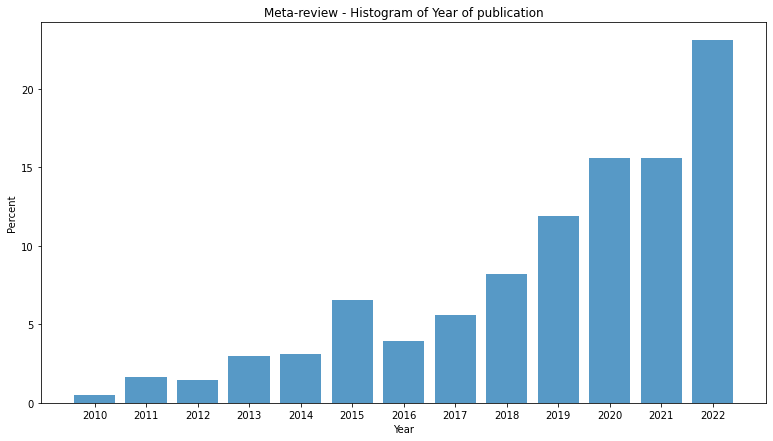

In [353]:
plt.figure(figsize=(13, 7))
sns.histplot(data=dfReview[dfReview.Year.notnull()], x='Year', stat='percent', bins=13, shrink=.8)

plt.xticks(np.arange(2010.5, 2023.5, step=1), np.arange(2010, 2023, step=1)) 
plt.title('Meta-review - Histogram of Year of publication')
plt.show()

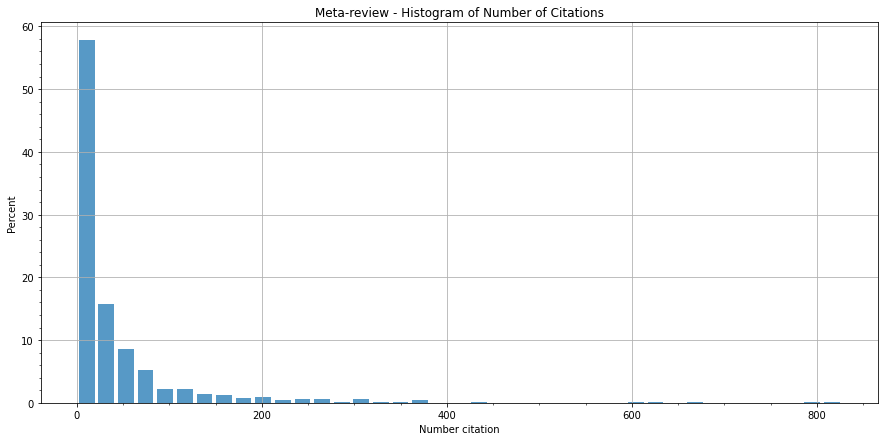

(-0.198, 5.051]       221
(5.051, 10.103]        99
(10.103, 15.154]       57
(15.154, 20.205]       51
(25.256, 30.308]       33
(30.308, 35.359]       32
(20.205, 25.256]       31
(35.359, 40.41]        25
(50.513, 55.564]       16
(55.564, 60.615]       16
(40.41, 45.462]        16
(60.615, 65.667]       14
(45.462, 50.513]       12
(75.769, 80.821]       12
(70.718, 75.769]       11
(80.821, 85.872]        7
(121.231, 126.282]      7
(136.385, 141.436]      6
(65.667, 70.718]        6
(95.974, 101.026]       5
(90.923, 95.974]        4
(101.026, 106.077]      4
(106.077, 111.128]      4
(191.949, 197.0]        4
(111.128, 116.179]      3
(116.179, 121.231]      3
(85.872, 90.923]        3
(161.641, 166.692]      3
(186.897, 191.949]      2
(126.282, 131.333]      2
(146.487, 151.538]      2
(151.538, 156.59]       2
(166.692, 171.744]      2
(141.436, 146.487]      2
(131.333, 136.385]      1
(156.59, 161.641]       1
(171.744, 176.795]      1
(176.795, 181.846]      1
(181.846, 18

In [356]:
cut_line = 200

plt.figure(figsize=(15, 7))

sns.histplot(
    data=dfReview[dfReview['Number citation'].notnull()], x='Number citation', stat='percent', bins=39, shrink=.8
)

plt.title('Meta-review - Histogram of Number of Citations')
plt.minorticks_on()
plt.grid()
plt.show()

print(dfReview[dfReview['Number citation'] < cut_line]['Number citation'].value_counts(bins=39))
print('More than ', cut_line, 'citations', (dfReview['Number citation'] > cut_line).sum())
print('Removing less than 5 citations: ', len(dfReview) - 881, 'papers')

### Modeling

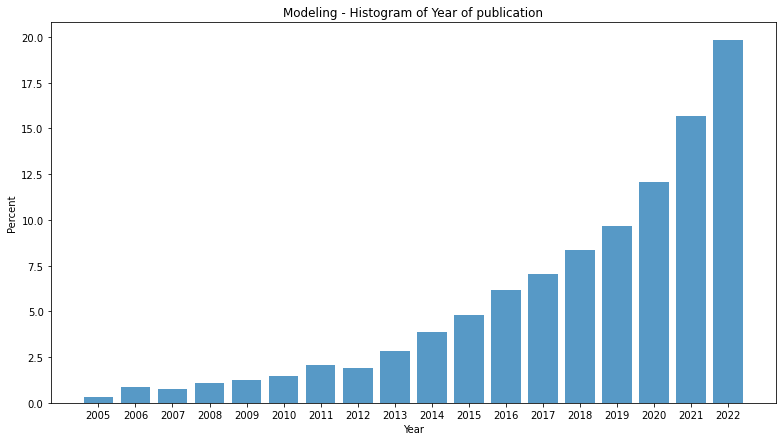

In [357]:
plt.figure(figsize=(13, 7))

sns.histplot(data=dfModel[dfModel.Year.notnull()], x='Year', stat='percent', bins=18, shrink=.8)

plt.xticks(np.arange(2005.5, 2023.5, step=1), np.arange(2005, 2023, step=1)) 
plt.title('Modeling - Histogram of Year of publication')
plt.show()

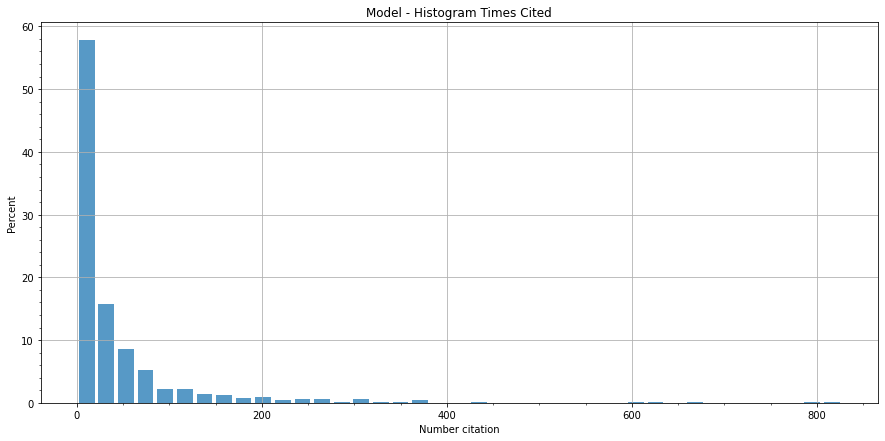

(-0.198, 5.051]       1990
(5.051, 10.103]        789
(10.103, 15.154]       527
(15.154, 20.205]       347
(20.205, 25.256]       245
(25.256, 30.308]       218
(30.308, 35.359]       143
(35.359, 40.41]        140
(40.41, 45.462]        107
(50.513, 55.564]        75
(45.462, 50.513]        73
(55.564, 60.615]        57
(60.615, 65.667]        47
(65.667, 70.718]        38
(70.718, 75.769]        31
(75.769, 80.821]        24
(80.821, 85.872]        24
(85.872, 90.923]        20
(90.923, 95.974]        19
(95.974, 101.026]       15
(106.077, 111.128]      13
(116.179, 121.231]      13
(131.333, 136.385]      11
(101.026, 106.077]      11
(141.436, 146.487]       9
(126.282, 131.333]       7
(151.538, 156.59]        7
(111.128, 116.179]       6
(121.231, 126.282]       6
(171.744, 176.795]       6
(161.641, 166.692]       5
(156.59, 161.641]        4
(191.949, 197.0]         4
(136.385, 141.436]       3
(186.897, 191.949]       3
(146.487, 151.538]       2
(176.795, 181.846]       2
(

In [355]:
cut_line = 200

plt.figure(figsize=(15, 7))

sns.histplot(
    data=dfReview[dfReview['Number citation'].notnull()], x='Number citation', stat='percent', bins=39, shrink=.8
)


plt.title('Model - Histogram of Number of Citations')
plt.minorticks_on()
plt.grid()
plt.show()

print(dfModel[dfModel['Number citation'] < cut_line]['Number citation'].value_counts(bins=39))
print('More than ', cut_line, 'citations', (dfModel['Number citation'] > cut_line).sum())
print('Removing less than 5 citations: ', len(dfModel) - 2046, 'papers')